In [373]:
!pip install torch torchvision numpy
!pip install higher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [374]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import higher
import itertools
from copy import deepcopy
import time

Load FashionMNIST dataset (Coat/Pullover): Create an imbalanced dataset, small_balanced dataset and testset

In [429]:
# Load the COAT and PULLOVER classes from FashionMNIST dataset
def get_imbalanced_and_small_balanced_dataset(train_dataset, imb_ratio, small_ratio=0.002, size = 5000):
  coat_size = int(size*imb_ratio)
  pullover_size = int(size-coat_size)
  small_size = int(size*small_ratio)
  # Filter out the coat and pullover classes
  train_coat_idxs = np.where(np.array(train_dataset.targets) == 2)[0] #total 6000 samples
  train_pullover_idxs = np.where(np.array(train_dataset.targets) == 4)[0]  #total 6000samples

  # Create an imbalanced training set
  imbalanced_train_idxs = np.concatenate([train_coat_idxs[:coat_size], train_pullover_idxs[:pullover_size]]) 
  imbalanced_train_set = Subset(train_dataset, imbalanced_train_idxs)
  imbalanced_train_loader = DataLoader(imbalanced_train_set, batch_size=32, shuffle=True)

  # Create a small balanced training set 0.02% of training dataset
  small_balanced_train_idxs = np.concatenate([train_coat_idxs[:int(small_size/2)], train_pullover_idxs[:int(small_size/2)]])
  small_balanced_train_set = Subset(train_dataset, small_balanced_train_idxs)
  small_balanced_train_loader = DataLoader(small_balanced_train_set, batch_size=32, shuffle=True)

  print('Small Balanced train dataset size:', small_size, '/Coat:',len(train_coat_idxs[:int(small_size/2)]) ,'/Pullover:',len(train_pullover_idxs[:int(small_size/2)]))
  print('Imbalanced train dataset size:', size, '/Coat:',len(train_coat_idxs[:coat_size]) ,'/Pullover:',len(train_pullover_idxs[:pullover_size]))
  return imbalanced_train_loader,small_balanced_train_loader

# Create a fixed test set
def get_test_dataset(test_dataset):
  test_coat_idxs = np.where(np.array(test_dataset.targets) == 2)[0]
  test_pullover_idxs = np.where(np.array(test_dataset.targets) == 4)[0]
  test_idxs = np.concatenate([test_coat_idxs, test_pullover_idxs])
  test_set = Subset(test_dataset, test_idxs)
  test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
  print('Test dataset size:', len(test_set),'/Coat:', len(test_coat_idxs),'/Pullover:', len(test_pullover_idxs))
  return test_loader


Base Model: LeNet5()

In [407]:
# Define a base model to train on training set
class LeNet5(nn.Module):          
  def __init__(self):     
      super(LeNet5, self).__init__()
      self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
      self.pool1 = nn.MaxPool2d(kernel_size=2)
      self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
      self.pool2 = nn.MaxPool2d(kernel_size=2) 
      self.fc1 = nn.Linear(16*4*4, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 5)

  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.pool1(x)
      x = F.relu(self.conv2(x))
      x = self.pool2(x)
      x = x.view(-1, 16*4*4)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x).squeeze()
      return x

Function: Train Base Model (model, optimizer, criterion, train_loader, device)

In [377]:
# Define a function to train the base model
def train_base(model, optimizer, criterion, train_loader, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0
  for i, (inputs, targets) in enumerate(train_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * outputs.shape[0]
      _, predicted = torch.max(outputs.data, 1)
      correct += predicted.eq(targets.data).cpu().sum()
  epoch_loss = running_loss / len(train_loader.dataset)
  epoch_acc = correct.numpy() / len(train_loader.dataset)
  return epoch_loss, epoch_acc

Function: Train Model with reweight (model, optimizer, criterion, imbalanced_train_loader, small_train_loader, device) with Higher

In [378]:
from matplotlib.rcsetup import reduce
# Define function to train the model
def train_reweight(model, optimizer, criterion, imbalanced_train_loader, small_train_loader, device):
    # Set model to train mode
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # Iterate over the training data
    optimizer.zero_grad()
    for i, (inputs, targets) in enumerate(imbalanced_train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # Sample mini-batch from imbalanced_train_loader and small_train_loader in mini_model
        with higher.innerloop_ctx(model, optimizer) as (mini_model, mini_optimizer):
          # Forward pass for imbalanced_train_loader and compute loss
          imb_out = mini_model(inputs)
          criterion.reduction = 'none'
          imb_loss = criterion(imb_out, targets)
          eps = torch.zeros(imb_loss.size(), requires_grad=True, device=device)
          imb_loss = torch.sum(eps * imb_loss)
          mini_optimizer.step(imb_loss)
          #--------------------------------------------------------------------------------------------------
          # Forward pass for small_train_loader and compute loss
          small_in, small_tar = next(iter(small_train_loader))
          small_in, small_tar = small_in.to(device), small_tar.to(device)
          small_out = mini_model(small_in)
          criterion.reduction = 'mean'
          small_loss = criterion(small_out, small_tar)
          eps_grads = torch.autograd.grad(small_loss, eps)[0].detach()
        #--------------------------------------------------------------------------------------------------
        # Compute weight and update
        w_t = torch.clamp(-eps_grads, min=0)
        w_n = torch.sum(w_t)
        if w_n != 0:
            w = w_t / w_n 
        else:
            w = w_t
        
        # Compute reweighted loss for imbalanced_train_loader and update parameters
        outputs = model(inputs)
        criterion.reduction = 'none'
        mini_loss = criterion(outputs, targets)
        mini_loss = torch.sum(mini_loss * w)
        # Backward pass Compute gradient and update parameters
        mini_loss.backward()
        optimizer.step()

        running_loss += mini_loss.item() * outputs.shape[0]
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(targets.data).cpu().sum()
    epoch_loss = running_loss / len(imbalanced_train_loader.dataset)
    epoch_acc = correct.numpy() / len(imbalanced_train_loader.dataset)
    return epoch_loss, epoch_acc

**Failed** to implement w/o Higher (Can't calculate second gradient)

In [379]:
# from torch.autograd import grad
# #RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

# # Define function to train the model
# def train_reweight0(model, optimizer, criterion, imbalanced_train_loader, small_train_loader, device):
#     # Set model to train mode
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     mini_model = deepcopy(model)
#     mini_optimizer = optim.SGD(mini_model.parameters(), lr=0.001)
#     mini_model.load_state_dict(model.state_dict())
#     #inputs, targets = inputs.to(device), targets.to(device)
#     # Sample mini-batch from imbalanced_train_loader and small_train_loader in mini_model
#     imb_in, imb_tar = next(iter(imbalanced_train_loader))
#     imb_in, imb_tar = imb_in.to(device), imb_tar.to(device)
#     small_in, small_tar = next(iter(small_train_loader))
#     small_in, small_tar = small_in.to(device), small_tar.to(device)
#     # Forward pass for imbalanced_train_loader and compute loss
#     imb_out = mini_model(imb_in)
#     criterion.reduction = 'none'
#     imb_loss = criterion(imb_out, imb_tar)
#     eps = torch.zeros(imb_loss.size(), requires_grad=True, device=device)
#     imb_loss = torch.sum(eps * imb_loss)
#     optimizer.step()
#     #--------------------------------------------------------------------------------------------------
#     # Forward pass for small_train_loader and compute loss
#     small_out = mini_model(small_in)
#     criterion.reduction = 'mean'
#     small_loss = criterion(small_out, small_tar)
#     eps_grads = torch.autograd.grad(small_loss, eps, create_graph=True)[0].detach()
#     #--------------------------------------------------------------------------------------------------
#     # Compute weight and update
#     w_t = torch.clamp(-eps_grads, min=0)
#     w_n = torch.sum(w_t)
#     if w_n != 0:
#       w = w_t / w_n
#     else:
#       w = w_t
  
#     # Compute reweighted loss for imbalanced_train_loader and update parameters
#     outputs = model(imb_in)
#     criterion.reduction = 'none'
#     mini_loss = criterion(outputs, imb_tar)
#     mini_loss = torch.sum(mini_loss * w)
#     # Backward pass Compute gradient and update parameters
#     optimizer.zero_grad()
#     mini_loss.backward()
#     optimizer.step()

#     running_loss += mini_loss.item() * outputs.shape[0]
#     _, predicted = torch.max(outputs.data, 1)
#     correct += predicted.eq(imb_tar.data).cpu().sum()
#     epoch_loss = running_loss / len(imbalanced_train_loader.dataset)
#     epoch_acc = correct.numpy() / len(imbalanced_train_loader.dataset)
#     return epoch_loss, epoch_acc


In [380]:
# Define a function to evaluate the base model
def evaluate(model, criterion, test_loader, device):
    model.eval()
    criterion.reduction = 'mean'
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * outputs.shape[0]
            _, predicted = torch.max(outputs.data, 1)
            correct += predicted.eq(targets.data).cpu().sum()
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct.numpy() / len(test_loader.dataset)
    return epoch_loss, epoch_acc


In [381]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Load FashionMNIST dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True,transform=transform)
# Load test set
test_dataset = FashionMNIST(root='./data', train=False, download=True,transform=transform)

In [449]:
# Train the base model on the close "IMBALANCED" training set with differnt ratio on training data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
base_train_loss_diff_ratio = []
base_train_accs_diff_ratio = []
base_test_loss_diff_ratio = []
base_test_accs_diff_ratio = []
imb_ratio_list = [0.6,0.7,0.8,0.9,0.95,0.99]
for imb_ratio in imb_ratio_list:
  model = LeNet5().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr=0.001)
  print(f"-----------------------------------------------------------------------------------------------------")
  print(f"Imbalanced dataset ratio(coat/pullover): {imb_ratio}")
  imbalanced_train_loader, small_balanced_train_loader = get_imbalanced_and_small_balanced_dataset(train_dataset,imb_ratio)
  test_loader = get_test_dataset(test_dataset)
  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(num_epochs):
      train_loss, train_acc = train_base(model, optimizer, criterion, imbalanced_train_loader, device)
      test_loss, test_acc = evaluate(model, criterion, test_loader, device)
      print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
      test_losses.append(test_loss)
      test_accs.append(test_acc)
      train_losses.append(train_loss)
      train_accs.append(train_acc)
  base_test_loss_diff_ratio.append(test_losses)
  base_test_accs_diff_ratio.append(test_accs)
  base_train_loss_diff_ratio.append(train_losses)
  base_train_accs_diff_ratio.append(train_accs)
  #print average test_loss, test_acc, train_loss, train_acc
  print(f"Test Loss: {sum(test_losses)/num_epochs:.4f}, Test Acc: {sum(test_accs)/num_epochs:.4f}")
  print(f"Train Loss: {sum(train_losses)/num_epochs:.4f}, Train Acc: {sum(train_accs)/num_epochs:.4f}")

-----------------------------------------------------------------------------------------------------
Imbalanced dataset ratio(coat/pullover): 0.6
Small Balanced train dataset size: 10 /Coat: 5 /Pullover: 5
Imbalanced train dataset size: 5000 /Coat: 3000 /Pullover: 2000
Test dataset size: 2000 /Coat: 1000 /Pullover: 1000
Epoch [1/10], Train Loss: 1.5713, Train Acc: 0.4000, Test Loss: 1.5186, Test Acc: 0.5000
Epoch [2/10], Train Loss: 1.4869, Train Acc: 0.4000, Test Loss: 1.4378, Test Acc: 0.5000
Epoch [3/10], Train Loss: 1.3951, Train Acc: 0.4494, Test Loss: 1.3440, Test Acc: 0.4990
Epoch [4/10], Train Loss: 1.2779, Train Acc: 0.5998, Test Loss: 1.2134, Test Acc: 0.5000
Epoch [5/10], Train Loss: 1.1062, Train Acc: 0.6000, Test Loss: 1.0273, Test Acc: 0.5000
Epoch [6/10], Train Loss: 0.9058, Train Acc: 0.6000, Test Loss: 0.8725, Test Acc: 0.5000
Epoch [7/10], Train Loss: 0.7826, Train Acc: 0.6000, Test Loss: 0.7913, Test Acc: 0.5000
Epoch [8/10], Train Loss: 0.7285, Train Acc: 0.6000, T

In [441]:
# Train the base model on the small balanced with Imbalanced training set in small ratio
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loss_diff_ratio = []
train_accs_diff_ratio = []
test_loss_diff_ratio = []
test_accs_diff_ratio = []
num_epochs = 10
imb_ratio_list = [0.6,0.7,0.8,0.9,0.95,0.99]
for imb_ratio in imb_ratio_list:
  model = LeNet5().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr=0.001)
  print(f"-----------------------------------------------------------------------------------------------------")
  print(f"Imbalanced dataset ratio(coat/pullover): {imb_ratio}")
  imbalanced_train_loader, small_balanced_train_loader = get_imbalanced_and_small_balanced_dataset(train_dataset,imb_ratio)
  test_loader = get_test_dataset(test_dataset)
  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(num_epochs):
      train_loss, train_acc = train_reweight(model, optimizer, criterion, imbalanced_train_loader, small_balanced_train_loader, device)
      test_loss, test_acc = evaluate(model, criterion, test_loader, device)
      print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
      test_losses.append(test_loss)
      test_accs.append(test_acc)
      train_losses.append(train_loss)
      train_accs.append(train_acc)
      
  test_loss_diff_ratio.append(test_losses)
  test_accs_diff_ratio.append(test_accs)
  train_loss_diff_ratio.append(train_losses)
  train_accs_diff_ratio.append(train_accs)
  #print average test_loss, test_acc, train_loss, train_acc
  print(f"Test Loss: {sum(test_losses)/num_epochs:.4f}, Test Acc: {sum(test_accs)/num_epochs:.4f}")
  print(f"Train Loss: {sum(train_losses)/num_epochs:.4f}, Train Acc: {sum(train_accs)/num_epochs:.4f}")

-----------------------------------------------------------------------------------------------------
Imbalanced dataset ratio(coat/pullover): 0.6
Small Balanced train dataset size: 10 /Coat: 5 /Pullover: 5
Imbalanced train dataset size: 5000 /Coat: 3000 /Pullover: 2000
Test dataset size: 2000 /Coat: 1000 /Pullover: 1000
Epoch [1/10], Train Loss: 1.1372, Train Acc: 0.4820, Test Loss: 0.7042, Test Acc: 0.5000
Epoch [2/10], Train Loss: 0.7119, Train Acc: 0.4880, Test Loss: 0.6945, Test Acc: 0.5400
Epoch [3/10], Train Loss: 0.7624, Train Acc: 0.5634, Test Loss: 0.6950, Test Acc: 0.5260
Epoch [4/10], Train Loss: 0.6479, Train Acc: 0.5554, Test Loss: 0.7723, Test Acc: 0.5805
Epoch [5/10], Train Loss: 0.6369, Train Acc: 0.6560, Test Loss: 0.6607, Test Acc: 0.7505
Epoch [6/10], Train Loss: 0.7940, Train Acc: 0.6762, Test Loss: 0.6897, Test Acc: 0.5930
Epoch [7/10], Train Loss: 0.6696, Train Acc: 0.6268, Test Loss: 0.5800, Test Acc: 0.7005
Epoch [8/10], Train Loss: 0.6427, Train Acc: 0.7462, T

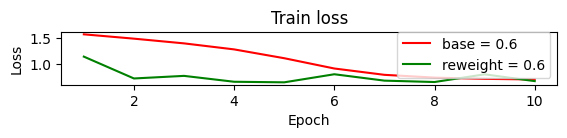

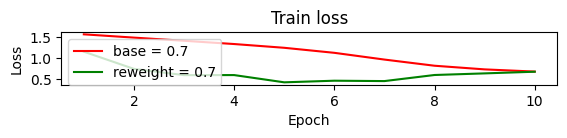

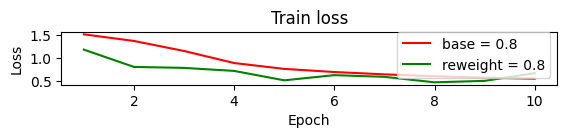

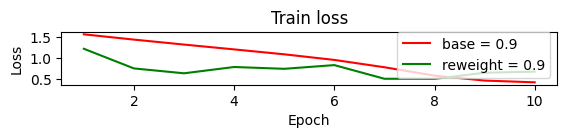

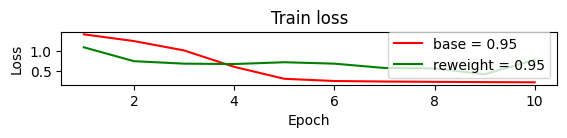

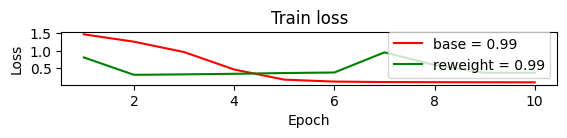

In [496]:

imb_ratio_list = [0.6,0.7,0.8,0.9,0.95,0.99]
ep = np.linspace(1, len(base_train_loss_diff_ratio[0]),len(base_train_loss_diff_ratio[0]))

for i in range(0,6):
  
  plt.title("Train loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.plot(ep,base_train_loss_diff_ratio[i],color = 'r',label = f'base = {imb_ratio_list[i]}')
  plt.plot(ep,train_loss_diff_ratio[i],color = 'g',label = f'reweight = {imb_ratio_list[i]}')
  plt.legend()
  plt.show()

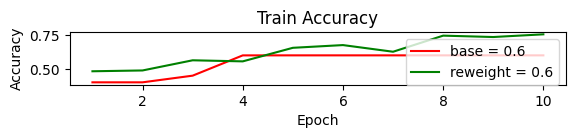

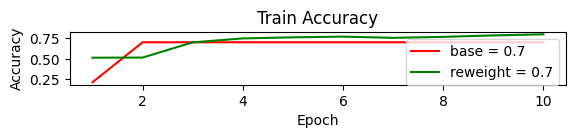

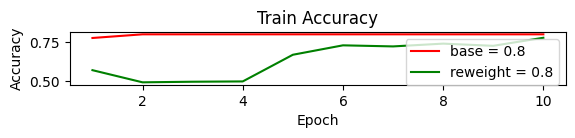

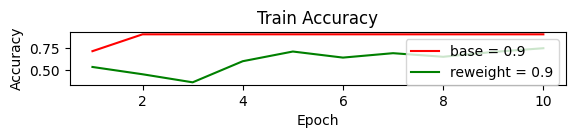

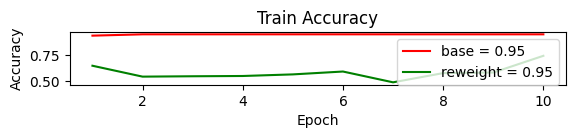

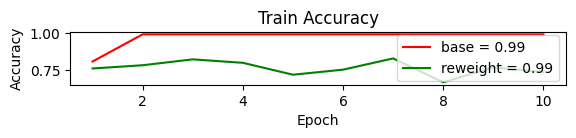

In [498]:

ep = np.linspace(1, len(base_train_accs_diff_ratio[0]),len(base_train_accs_diff_ratio[0]))

imb_ratio_list = [0.6,0.7,0.8,0.9,0.95,0.99]
for i in range(0,6):
  plt.subplot(6,1,i+1)
  plt.title("Train Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.plot(ep,base_train_accs_diff_ratio[i],color = 'r',label = f'base = {imb_ratio_list[i]}')
  plt.plot(ep,train_accs_diff_ratio[i],color = 'g',label = f'reweight = {imb_ratio_list[i]}')
  plt.legend()
  plt.show()

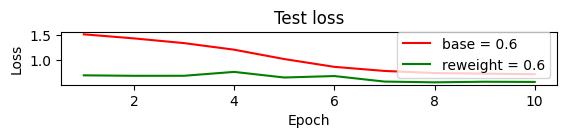

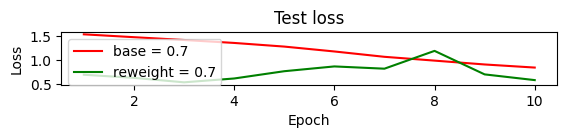

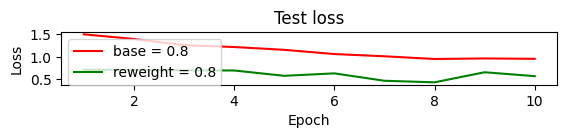

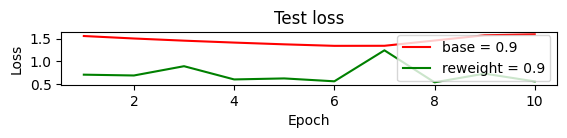

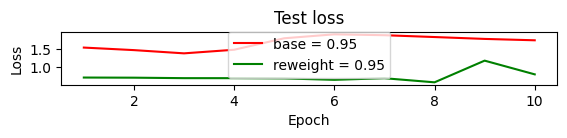

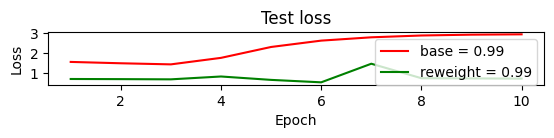

In [497]:

ep = np.linspace(1, len(base_test_loss_diff_ratio[0]),len(base_test_loss_diff_ratio[0]))
imb_ratio_list = [0.6,0.7,0.8,0.9,0.95,0.99]
for i in range(0,6):
  plt.subplot(6,1,i+1)
  plt.title("Test loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss") 
  plt.plot(ep,base_test_loss_diff_ratio[i],color = 'r',label = f'base = {imb_ratio_list[i]}')
  plt.plot(ep,test_loss_diff_ratio[i],color = 'g',label = f'reweight = {imb_ratio_list[i]}')
  plt.legend()
  plt.show()

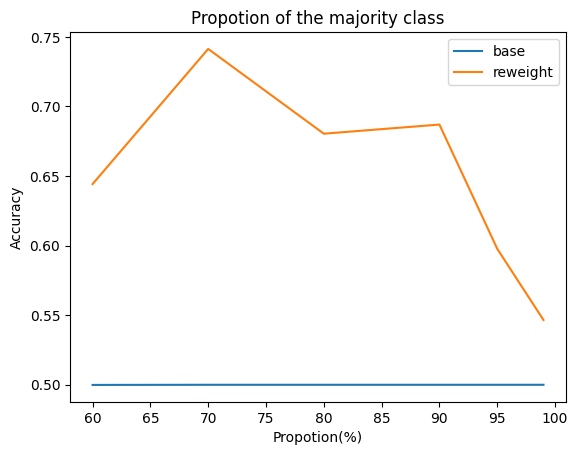

In [499]:
plt.title("Propotion of the majority class")
imb_ratio_list = [60,70,80,90,95,99]
num_epochs = 10
plt.xlabel("Propotion(%)")
plt.ylabel("Accuracy")
avg_base_accs = []
avg_rew_accs = []
for i in range(0,6):
  avg_base_accs.append(np.mean(base_test_accs_diff_ratio[i]))
  avg_rew_accs.append(np.mean(test_accs_diff_ratio[i]))

plt.plot(imb_ratio_list,avg_base_accs,label='base')
plt.plot(imb_ratio_list,avg_rew_accs,label='reweight')
plt.legend()
plt.show()